In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(16,8)})

In [3]:
# df_esb = pd.read_csv('../data/2020_05_04/esb.csv').drop('serviceName', axis=1)
df_esb = pd.read_csv('../data/test_data/esb_test.csv').drop('serviceName', axis=1)
df_esb['startTime'] = pd.to_datetime(df_esb['startTime'], unit='ms')

# df_esb.set_index('startTime')

In [24]:
df_anom = pd.read_csv('../data/test_data/anomalies.csv')
df_anom['startTime'] = pd.to_datetime(df_anom['startTime'], unit='ms')
df_anom.head()

,Unnamed: 0,Unnamed: 0.1,serviceName,startTime,avg_time,num,succee_num,succee_rate
0,36,36,osb_001,2020-11-30 20:28:00,0.4231,496,143,0.2883
1,37,37,osb_001,2020-11-30 20:29:00,0.0000,465,0,0.0000
2,38,38,osb_001,2020-11-30 20:30:00,0.0000,493,0,0.0000
3,39,39,osb_001,2020-11-30 20:31:00,0.0000,456,0,0.0000
4,40,40,osb_001,2020-11-30 20:32:00,0.0000,544,0,0.0000


<AxesSubplot:xlabel='startTime', ylabel='num'>

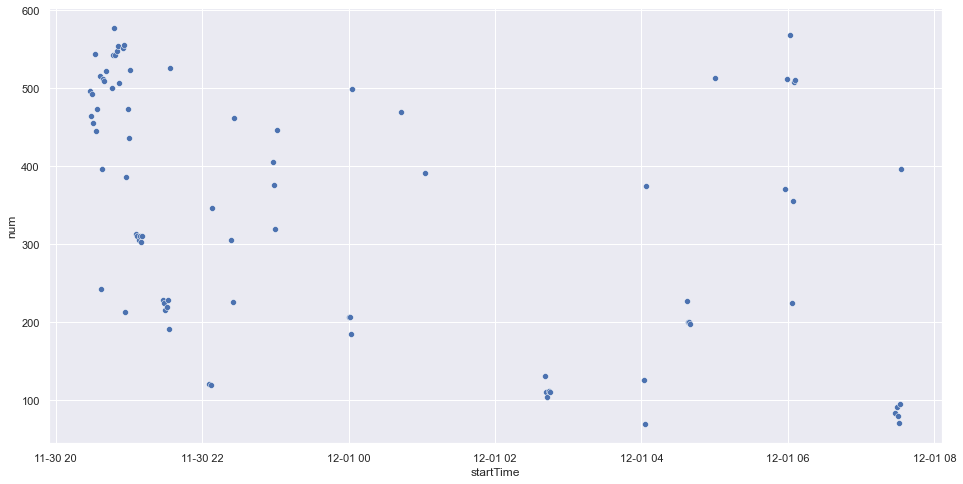

In [25]:
sns.scatterplot(data=df_anom, x="startTime", y="num")

In [4]:
df_esb.head()

,Unnamed: 0,startTime,avg_time,num,succee_num,succee_rate
0,0,2020-11-30 19:52:00,0.6295,453,453,1.0
1,1,2020-11-30 19:53:00,0.5889,452,452,1.0
2,2,2020-11-30 19:54:00,0.6599,405,405,1.0
3,3,2020-11-30 19:55:00,0.6391,447,447,1.0
4,4,2020-11-30 19:56:00,0.5856,465,465,1.0


In [5]:
df_esb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   744 non-null    int64         
 1   startTime    744 non-null    datetime64[ns]
 2   avg_time     744 non-null    float64       
 3   num          744 non-null    int64         
 4   succee_num   744 non-null    int64         
 5   succee_rate  744 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 35.0 KB


In [6]:
#RIP successes
df_esb.describe()

,Unnamed: 0,avg_time,num,succee_num,succee_rate
count,744.000000,744.000000,744.000000,744.000000,744.000000
mean,371.500000,0.838195,478.665323,466.532258,0.975608
std,214.918589,0.939114,97.721730,120.611660,0.148403
min,0.000000,0.000000,70.000000,0.000000,0.000000
25%,185.750000,0.602800,430.000000,420.500000,1.000000
50%,371.500000,0.636500,490.000000,481.500000,1.000000
75%,557.250000,0.688975,548.000000,548.000000,1.000000
max,743.000000,9.848100,652.000000,652.000000,1.000000


<AxesSubplot:xlabel='startTime', ylabel='num'>

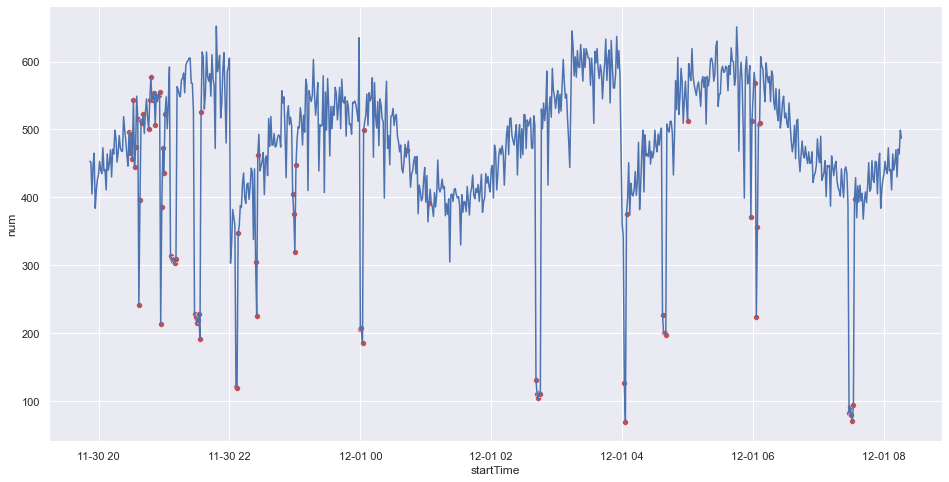

In [28]:
sns.lineplot(x='startTime', y='num', data=df_esb)
sns.scatterplot(x="startTime", y="num", data=df_anom, color='r')

<AxesSubplot:xlabel='startTime', ylabel='avg_time'>

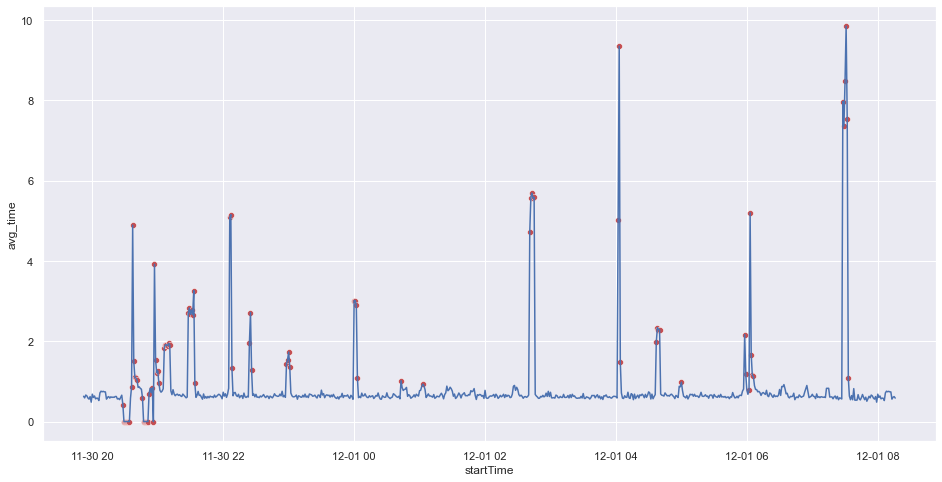

In [30]:
sns.lineplot(x='startTime', y='avg_time', data=df_esb)
sns.scatterplot(x="startTime", y="avg_time", data=df_anom, color='r')

In [9]:
def complete_timestamp(timestamp, arrays=None):
    """
    Complete `timestamp` such that the time interval is homogeneous.
    Zeros will be inserted into each array in `arrays`, at missing points.
    Also, an indicator array will be returned to indicate whether each
    point is missing or not.
    Args:
        timestamp (np.ndarray): 1-D int64 array, the timestamp values.
            It can be unsorted.
        arrays (Iterable[np.ndarray]): The 1-D arrays to be filled with zeros
            according to `timestamp`.
    Returns:
        np.ndarray: A 1-D int64 array, the completed timestamp.
        np.ndarray: A 1-D int32 array, indicating whether each point is missing.
        list[np.ndarray]: The arrays, missing points filled with zeros.
            (optional, return only if `arrays` is specified)
    """
    timestamp = np.asarray(timestamp, np.int64)
    if len(timestamp.shape) != 1:
        raise ValueError('`timestamp` must be a 1-D array')

    has_arrays = arrays is not None
    arrays = [np.asarray(array) for array in (arrays or ())]
    for i, array in enumerate(arrays):
        if array.shape != timestamp.shape:
            raise ValueError('The shape of ``arrays[{}]`` does not agree with '
                             'the shape of `timestamp` ({} vs {})'.
                             format(i, array.shape, timestamp.shape))

    # sort the timestamp, and check the intervals
    src_index = np.argsort(timestamp)
    timestamp_sorted = timestamp[src_index]
    intervals = np.unique(np.diff(timestamp_sorted))
    interval = np.min(intervals)
    if interval == 0:
        raise ValueError('Duplicated values in `timestamp`')
    for itv in intervals:
        if itv % interval != 0:
            raise ValueError('Not all intervals in `timestamp` are multiples '
                             'of the minimum interval')

    # prepare for the return arrays
    length = (timestamp_sorted[-1] - timestamp_sorted[0]) // interval + 1
    ret_timestamp = np.arange(timestamp_sorted[0],
                              timestamp_sorted[-1] + interval,
                              interval,
                              dtype=np.int64)
    ret_missing = np.ones([length], dtype=np.int32)
    ret_arrays = [np.zeros([length], dtype=array.dtype) for array in arrays]

    # copy values to the return arrays
    dst_index = np.asarray((timestamp_sorted - timestamp_sorted[0]) // interval,
                           dtype=np.int)
    ret_missing[dst_index] = 0
    for ret_array, array in zip(ret_arrays, arrays):
        ret_array[dst_index] = array[src_index]

    if has_arrays:
        return ret_timestamp, ret_missing, ret_arrays
    else:
        return ret_timestamp, ret_missing


def standardize_kpi(values, mean=None, std=None, excludes=None):
    """
    Standardize a
    Args:
        values (np.ndarray): 1-D `float32` array, the KPI observations.
        mean (float): If not :obj:`None`, will use this `mean` to standardize
            `values`. If :obj:`None`, `mean` will be computed from `values`.
            Note `mean` and `std` must be both :obj:`None` or not :obj:`None`.
            (default :obj:`None`)
        std (float): If not :obj:`None`, will use this `std` to standardize
            `values`. If :obj:`None`, `std` will be computed from `values`.
            Note `mean` and `std` must be both :obj:`None` or not :obj:`None`.
            (default :obj:`None`)
        excludes (np.ndarray): Optional, 1-D `int32` or `bool` array, the
            indicators of whether each point should be excluded for computing
            `mean` and `std`. Ignored if `mean` and `std` are not :obj:`None`.
            (default :obj:`None`)
    Returns:
        np.ndarray: The standardized `values`.
        float: The computed `mean` or the given `mean`.
        float: The computed `std` or the given `std`.
    """
    values = np.asarray(values, dtype=np.float32)
    if len(values.shape) != 1:
        raise ValueError('`values` must be a 1-D array')
    if (mean is None) != (std is None):
        raise ValueError('`mean` and `std` must be both None or not None')
    if excludes is not None:
        excludes = np.asarray(excludes, dtype=np.bool)
        if excludes.shape != values.shape:
            raise ValueError('The shape of `excludes` does not agree with '
                             'the shape of `values` ({} vs {})'.
                             format(excludes.shape, values.shape))

    if mean is None:
        if excludes is not None:
            val = values[np.logical_not(excludes)]
        else:
            val = values
        mean = val.mean()
        std = val.std()

    return (values - mean) / std, mean, std


def standardize_kpi_df(df, column_name, new_column=None):
    if(new_column is None):
        new_column = column_name 
        
    df[new_column] = (df[column_name] - df[column_name].mean())
    return df

# def differenciate_df(df, periods=1, freq='1M'):
    

In [10]:
#df_esb['avg_time_st'] = (df_esb['avg_time'] - df_esb['avg_time'].mean()) #/ df_esb['avg_time'].std()

df_esb = standardize_kpi_df(df_esb, column_name='avg_time', new_column='avg_time_st')
df_esb = standardize_kpi_df(df_esb, column_name='num', new_column='num_st')
df_esb = standardize_kpi_df(df_esb, column_name='succee_rate', new_column='succee_rate_st')

df_esb['num_diff'] = df_esb['num'].diff(1)
df_esb = standardize_kpi_df(df_esb, column_name='num_diff', new_column='num_diff_st')

In [11]:
df_esb_10 = df_esb.set_index(['startTime']).resample('10Min')
df_esb_60 = df_esb.set_index(['startTime']).resample('60Min')

# df_esb_diff = df_esb.pct_change()

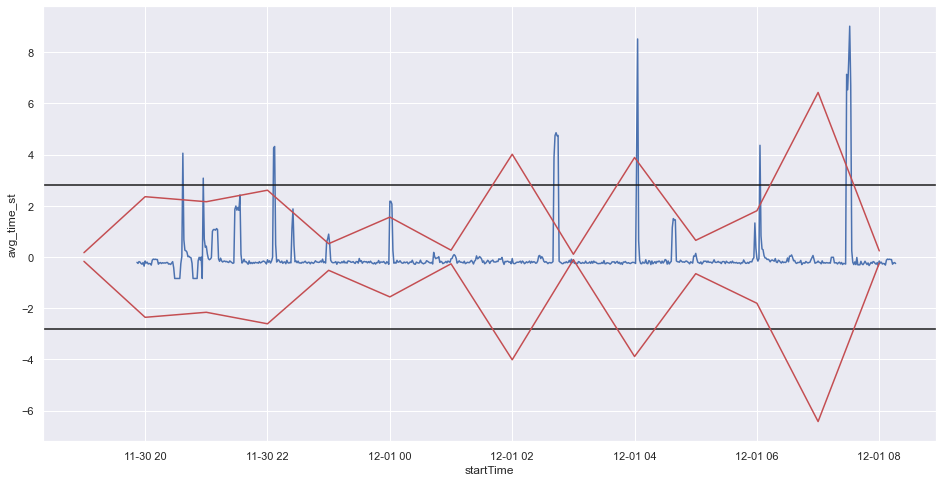

In [12]:
sns.lineplot(x='startTime', y='avg_time_st', data=df_esb)

fixed_threshold = 3 * df_esb['avg_time'].std()
plt.axhline(fixed_threshold, color='k')
plt.axhline(-fixed_threshold, color='k')

rolling_threshold = 3 * df_esb_60['avg_time'].std()
plt.plot(rolling_threshold, color='r')
plt.plot(-rolling_threshold, color='r')

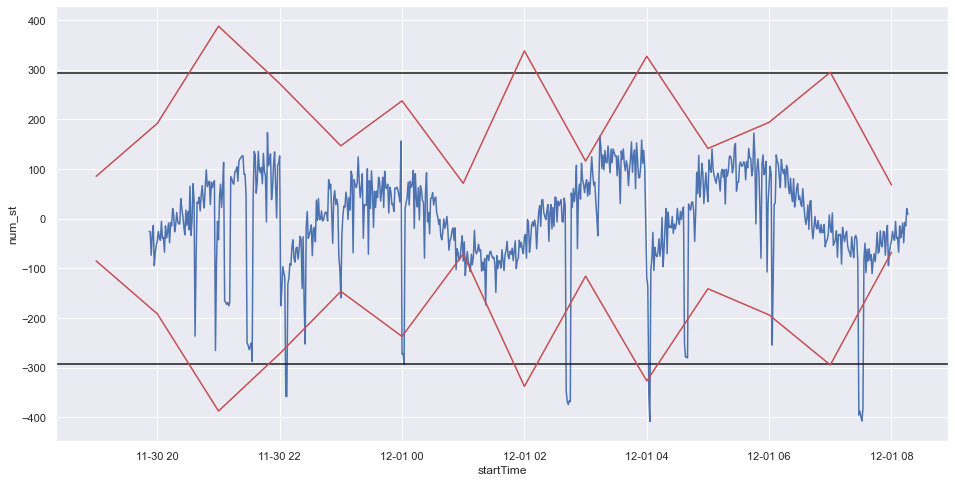

In [13]:
sns.lineplot(x='startTime', y='num_st', data=df_esb)

fixed_threshold = 3 * df_esb['num'].std()
plt.axhline(fixed_threshold, color='k')
plt.axhline(-fixed_threshold, color='k')

rolling_threshold = 3 * df_esb_60['num'].std()
plt.plot(rolling_threshold, color='r')
plt.plot(-rolling_threshold, color='r')

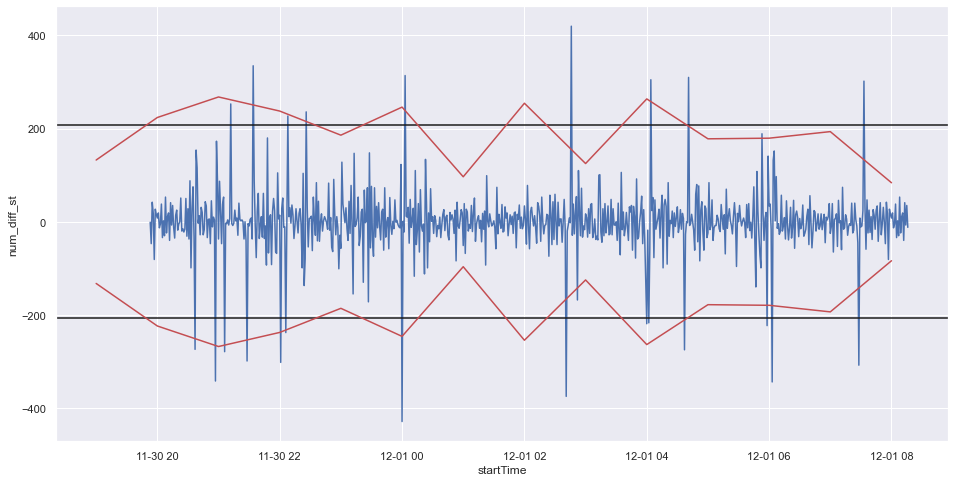

In [14]:
sns.lineplot(x='startTime', y='num_diff_st', data=df_esb)

fixed_threshold = 3 * df_esb['num_diff'].std()
plt.axhline(fixed_threshold, color='k')
plt.axhline(-fixed_threshold, color='k')

rolling_threshold = 3 * df_esb_60['num_diff'].std()
plt.plot(rolling_threshold, color='r')
plt.plot(-rolling_threshold, color='r')

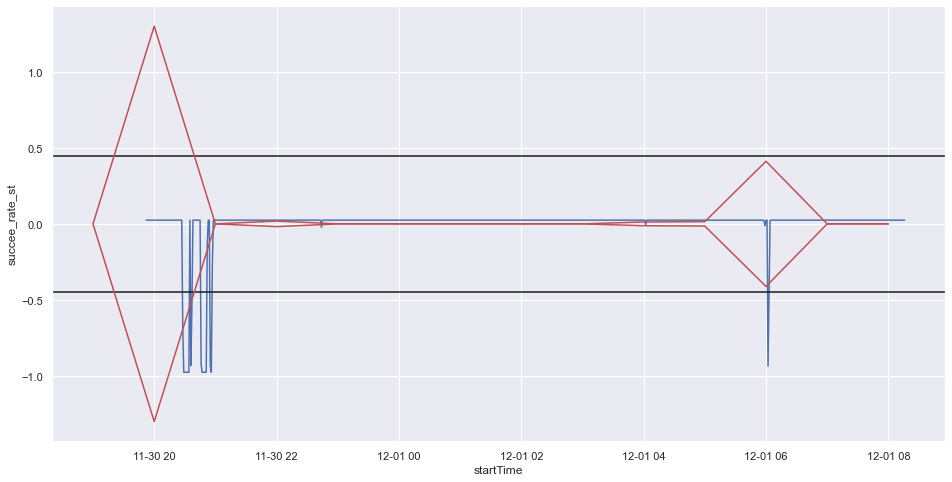

In [15]:
sns.lineplot(x='startTime', y='succee_rate_st', data=df_esb)

fixed_threshold = 3 * df_esb['succee_rate'].std()
plt.axhline(fixed_threshold, color='k')
plt.axhline(-fixed_threshold, color='k')

rolling_threshold = 3 * df_esb_60['succee_rate'].std()
plt.plot(rolling_threshold, color='r')
plt.plot(-rolling_threshold, color='r')

In [16]:
import math

class Welford(object):
    """ Implements Welford's algorithm for computing a running mean
    and standard deviation as described at: 
        http://www.johndcook.com/standard_deviation.html
    can take single values or iterables
    Properties:
        mean    - returns the mean
        std     - returns the std
        meanfull- returns the mean and std of the mean
    Usage:
        >>> foo = Welford()
        >>> foo(range(100))
        >>> foo
        <Welford: 49.5 +- 29.0114919759>
        >>> foo([1]*1000)
        >>> foo
        <Welford: 5.40909090909 +- 16.4437417146>
        >>> foo.mean
        5.409090909090906
        >>> foo.std
        16.44374171455467
        >>> foo.meanfull
        (5.409090909090906, 0.4957974674244838)
    """

    def __init__(self,lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        newM = self.M + (x - self.M)*1./self.k
        newS = self.S + (x - self.M)*(x - newM)
        self.M, self.S = newM, newS

    def consume(self,lst):
        lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    
    @property
    def meanfull(self):
        return self.mean, self.std/math.sqrt(self.k)
    
    @property
    def std(self):
        if self.k==1:
            return 0
        return math.sqrt(self.S/(self.k-1))
    
    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)

In [17]:
wf = Welford()

wf_mean = []
wf_std = []

for value in df_esb['num']:
    wf.update(value)
    wf_mean.append(wf.mean)
    wf_std.append(wf.std)
    
df_esb['num_welford_mean'] = wf_mean
df_esb['num_welford_std'] = wf_std

df_esb['num_wf_st'] = (df_esb['num'] - df_esb['num_welford_mean'])
# df_esb['num_st_threshold'] = wf_mean + (3*wf_std)

<AxesSubplot:xlabel='startTime', ylabel='num_wf_st'>

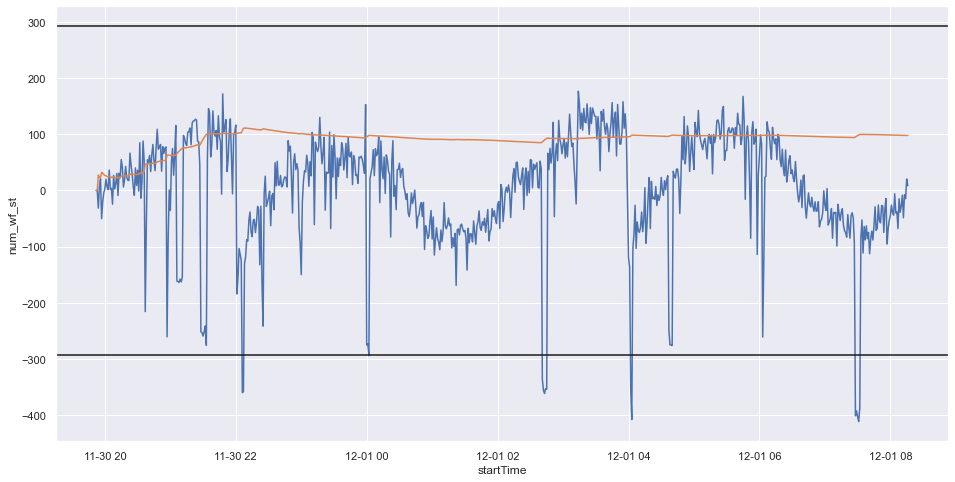

In [18]:
sns.lineplot(x='startTime', y='num_wf_st', data=df_esb)

fixed_threshold = 3 * df_esb['num_wf_st'].std()
plt.axhline(fixed_threshold, color='k')
plt.axhline(-fixed_threshold, color='k')

sns.lineplot(x='startTime', y='num_welford_std', data=df_esb)
# rolling_threshold = wf_std
# rolling_threshold = 3 * df_esb_60['num_wf_st'].std()
# plt.plot(rolling_threshold, color='r')
# plt.plot(-rolling_threshold, color='r')